# Partie 5: Contrôle de systèmes dynamiques I

- [Problématique générale](#PbGeneral)
- [Modélisation de systèmes dynamiques: les représentations d'état](#RepEtat)
- [Commande boucle ouverte et boucle fermée](#BOBF)
- [Contrôleur Proportionnel Intégral Dérivé (PID)](#PID)

Les parties sur le contrôleur PID sont tirées du livre édité en 2008 par Denis Dochain et intitulé "Automatic Control of Bioprocesses".

In [41]:
# -*- coding: utf-8 -*-
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Pour afficher le code python, cliquer sur le bouton: 
<button onclick="javascript:code_toggle()">Afficher code python</button>
''')

In [42]:
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed
#from IPython.html.widgets import interact, fixed
import scipy.integrate as scint
from matplotlib import patches as pat

## <a name="PbGeneral">Problèmatique générale</a>

### Objectif

L'objectif principal de l'automatique ou de la théorie du contrôle est d'imposer un comportement dynamique spécifique à un système en jouant sur les commandes disponibles: on dit alors que l'on commande ou contrôle le système.

<u>Exemples de comportements recherchés</u>:
- amener une quantité à atteindre une valeur désirée (régulation). Exemple: le chauffage
- stabilisation ou déstabilisation d'un système instable/stable. Exemple: lutte contre la prolifération d'insectes ravageurs
- poursuite d'une trajectoire. Exemple: missile

En plus de l'objectif à atteindre, il faut aussi respecter certaines contraintes.

<u>Exemples de contraintes</u>
- saturation de la commande. Exemple: débit maximum autorisé
- temps de réponse rapide
- peu d'oscillations
- minimisation de la consommation énergétique

### Comportement entrées/sorties

Quand on souhaite contrôler un système, on s'intéresse en fait à son comportement entrées/sorties, ce que l'on représente généralement de la manière suivante:

![Figure1](./images/SystemeEntreeSortie.jpg)

où:
- $u=(u_1,u_2,...,u_m)^T$ sont les entrées (vecteur), que l'on appelle aussi "actionneurs" ou "commandes"
- $y=(y_1,y_2,...,y_p)^T$ sont les sorties (vecteur)


### Design d'une loi de commande

Contrôler un système d'entrées $u$ et de sorties $y$ revient à chercher quelles entrées appliquer au système pour que les sorties se comportent comme on le souhaite.

> L'expression de $u$ est appelée **loi de commande**.

Il existe de nombreuses techniques permettant d'obtenir ces lois de commande. Certaines d'entre elles sont basées sur le modèle du système. 

## <a name="RepEtat">Modélisation de systèmes dynamiques: les représentations d'état</a>
Les systèmes étudiés peuvent être décrits par des modèles de types différents (EDO, EDP, modèles stochastiques, ...) qui sont fonction de la nature même du système, mais également de l'objectif de la modélisation (analyse, simulation, contrôle, etc.).  On s'intéresse ici aux systèmes dynamiques pouvant être décrits par un nombre fini d'équations différentielles ordinaires du premier ordre, c'est à dire des systèmes dits 'différentiels', de la forme:


\begin{equation}
 \left\{
\begin{array}{rcl}
 \dot{x_1} & = & f_1(x_1,x_2,...,x_n,u_1,u_2,...,u_m)\\
\dot{x_2} & = & f_2(x_1,x_2,...,x_n,u_1,u_2,...,u_m)\\
\vdots & = & \vdots \\
\dot{x_n} & = & f_n(x_1,x_2,...,x_n,u_1,u_2,...,u_m),
\end{array}
\right.
\end{equation}

où $\dot{x_i}$ représente la dérivée de la variable $x_i$ par rapport au temps $t$, aussi notée $\frac{dx_i}{dt}$. On ajoute à ce système une condition initiale  $x_0=(x_1(t_0), x_2(t_0), ... , x_n(t_0))^T$ et les sorties sont exprimées par une relation de la forme suivante:

\begin{equation}
 \left\{
\begin{array}{rcl}
{y_1} & = & h_1(x_1,x_2,...,x_n,u_1,u_2,...,u_m)\\
{y_2} & = & h_2(x_1,x_2,...,x_n,u_1,u_2,...,u_m)\\
\vdots & = & \vdots \\
{y_p} & = & h_p(x_1,x_2,...,x_n,u_1,u_2,...,u_m).
\end{array}
\right.
\end{equation}

De manière plus concise, on écrira, pour $x_0$ donné:

<a name="RepEtatNL"> \begin{equation}
(M_1)\,\left\{
\begin{array}{rcl}
 \dot{x}&=&f(x,u)\\
y&=&h(x,u)
\end{array}
\right.
\end{equation}</a>
avec  $x=(x_1,x_2,...,x_n)^T,\,u=(u_1,u_2,...,u_m)^T,\,y=(y_1,y_2,...,y_p)^T,$ $f=(f_1,f_2,...,f_n)^T$ et $h=(h_1,h_2,...,h_p)^T$.


![Figure2](./images/SystemeDiff.jpg)
_Figure 2. Système différentiel d'entrées $u$ et de sorties $y$_

**Terminologie**
* le modèle [$(M_1)$](#RepEtatNL) est appelé **modèle d'état** ou **représentation d'état**.
* $x(t)\in \mathbb{R}^n$ est le vecteur des **variables d'état**: à un instant $t$ donné, $x(t)$ caractérise entièrement le système. En effet, la connaissance de $x(t)$ et la donnée des entrées $u$ sur l'intervalle $[t,T]$ suffisent à déterminer, via le système [$(M_1)$](#RepEtatNL), l'évolution de $x$ sur l'intervalle $[t,T]$. On peut dire que l'état d'un système à un instant $t$ représente la mémoire minimale du passé nécessaire à la détermination du futur.
* $u(t)\in \mathbb{R}^m$ est le vecteur des **entrées** ou encore **commandes**. Elles représentent l'influence du monde extérieur sur le système considéré. C'est via ces variables que l'on va pouvoir chercher à contrôler le système.
* $y(t)\in \mathbb{R}^p$ est le vecteur des **sorties**.

> **Remarque**
> * $x$, $y$ et $u$ sont des fonctions du temps, à valeurs respectivement dans $\mathbb{R}^n$, $\mathbb{R}^p$ et $\mathbb{R}^m$. La dépendance en temps sera parfois marquée explicitement, et parfois omise.
> * Etant donnée une condition initiale $x_0=x(t_0)$, et pour une entrée $u$ donnée, la solution $x(t)$ pour $t\geqslant t_0$ de [$(M_1)$](#RepEtatNL) est appelée **trajectoire** du système. On suppose qu'une telle trajectoire existe toujours, est unique et continue.
> * Un même système admet une infinité de représentations d'état, chacune associée à un choix de variables d'état.
> * Le choix des variables d'état est arbitraire. Cependant, en fonction de l'objectif de la modélisation, certains choix peuvent s'avérer plus judicieux que d'autres (maintien de la signification physique des variables par exemple...).
> * Le nombre minimal de variables d'états nécessaires à la caractérisation du système correspond à l'**ordre du système**.
> * Lorsque l'entrée $u$ du système peut être librement choisie, on dit que le système est **commandé**, car on peut contrôler l'allure de la trajectoire $x$ en jouant sur le choix de $u$.


### Cas linéaire
Un cas particulier de modèles d'état sont les modèles d'état linéaires, c'est à dire des modèles de la forme:

<a name="RepEtatLin">
\begin{eqnarray}
 (M_2)\,\left\{
\begin{array}{rcl}
 \dot{x}&=&Ax+Bu,\\
y&=&Cx+Du,
\end{array}
\right.
\end{eqnarray}
</a>

avec $A\in \mathbb{R}^{n\times n}$, $B \in \mathbb{R}^{n \times m}$, $C\in \mathbb{R}^{p \times n}$ et $D \in \mathbb{R}^{p \times m}$.

C'est une classe de modèles importante, car plus simple à étudier que les modèles non linéaires et pour laquelle de nombreux outils (d'analyse, de commande, etc...) ont été developpés.

### Cas non linéaire
Les outils développés pour les modèles linéaires peuvent être également utilisés dans le cas non linéaire, après linéarisation autour d'un point d'équilibre du modèle considéré.


En effet, soit $\bar{x}$ un point d'équilibre de [$(M_1)$](#RepEtatNL) pour un $\bar{u}$ donné (c'est à dire un point $\bar{x}$ tel que $f(\bar{x},\bar{u})=0$), et $B$ une boule ouverte de $\mathbb{R}^n \times \mathbb{R}^p$ centrée en $(\bar{x},\bar{u})$.
On suppose $f: \mathbb{R}^n \times \mathbb{R}^p \mapsto \mathbb{R}^n$ de classe $\mathcal{C}^1$ sur $\bar{B}$, c'est à dire dérivable par rapport à $x_i$ et $u_j$ pour tout $i=1:n,\, j=1:m$ et de dérivées partielles continues. La formule de Taylor à l'ordre $1$ nous donne alors, pour tout $(\delta x, \delta u)$ tel que $(\bar{x}+\delta x,\bar{u}+\delta u) \in B$:

\begin{equation}
 f(\bar{x}+\delta x,\bar{u}+\delta u)=f(\bar{x},\bar{u})+J_{f,x}(\bar{x},\bar{u})\delta x +J_{f,u}(\bar{x},\bar{u})\delta u+R_1(\delta x , \delta u),
\end{equation}

où $J_{f,x}(\bar{x},\bar{u})$ est la matrice jacobienne de $x \mapsto f(x,u)$ en $(\bar{x},\bar{u})$, c'est à dire la matrice:

\begin{equation}
 J_{f,x}(\bar{x},\bar{u})=
\left[
\begin{array}{ccc}
 \partial_{x_1}f_1(\bar{x},\bar{u}) & ... & \partial_{x_n}f_1(\bar{x},\bar{u})\\
\vdots &  & \vdots \\
 \partial_{x_1}f_n(\bar{x},\bar{u}) & ... & \partial_{x_n}f_n(\bar{x},\bar{u})
\end{array}
\right] \in \mathbb{R}^{n\times n},
\end{equation}

$J_{f,u}(\bar{x},\bar{u})$ est la matrice jacobienne de $u \mapsto f(x,u)$ en $(\bar{x},\bar{u})$, c'est à dire la matrice:

\begin{equation}
 J_{f,u}(\bar{x},\bar{u})=
\left[
\begin{array}{ccc}
 \partial_{u_1}f_1(\bar{x},\bar{u}) & ... & \partial_{u_m}f_1(\bar{x},\bar{u})\\
\vdots &  & \vdots \\
 \partial_{u_1}f_n(\bar{x},\bar{u}) & ... & \partial_{u_m}f_n(\bar{x},\bar{u})
\end{array}
\right]\in \mathbb{R}^{n\times m},
\end{equation}

et $R_1(\delta x , \delta u)$ est un 'reste', qui est négligeable devant $\lVert (\delta x,\delta u)  \lVert$, ce que l'on note également $R_1(\delta x , \delta u)=o(\lVert (\delta x,\delta u) \lVert)$, c'est à dire:

\begin{equation}
 \lim_{\lVert (\delta x,\delta u) \lVert \rightarrow 0} \frac{R_1(\delta x,\delta u)}{\lVert (\delta x,\delta u) \lVert}=0.
\end{equation}

Comme $f(\bar{x},u)=0$, et si l'on considère des $\delta x=x-\bar{X}$ et $\delta u=u-\bar{u}$ suffisamment petits, on obtient l'approximation linéaire du système, donnée par:

<a name="RE">
\begin{equation}
(M_3)\, \left\{
\begin{array}{rcl}
 \dot{\delta x}&=&J_{f,x}(\bar{x},\bar{u})\delta x+J_{f,u}(\bar{x},\bar{u})\delta u,\\
y&=&h(\bar{x}+\delta x,\bar{u}+\delta u).
\end{array}
\right.
\end{equation}
</a>

## <a name="BOBF">Commande boucle ouverte et boucle fermée</a>

Une fois que l'on s'est assuré de l'éxistence d'une commande $u$, on s'intéresse au problème de sa conception, de son design. Plusieurs stratégies de commande sont envisageables: on distingue notamment les lois de commande en boucle ouverte et en boucle fermée.

### Commande en boucle ouverte

> **Définition**  
> Une **commande en boucle ouverte** (ou **contrôle en boucle ouverte**) est une application $u:t\mapsto c(t)$ qui ne dépend pas de l'état ou de la sortie du système. Bien choisie, elle peut permettre de réaliser un objectif donné, à condition que le système soit bien connu, que le modèle soit fiable (voir parfait), et qu'il n'y ait aucun imprévu.

![Figure 6](./images/SystemeBO.jpg)
<a name="SystemeBO">Figure 6. Commande en boucle ouverte d'un système différentiel d'entrées $u$ et de sorties $y$</a>


> **Exemple d'un remplissage d'un réservoir pour l'irrigation**

> <u>Problématique</u>: On s'intéresse au problème du remplissage d'un réservoir pour l'irrigation. Le réservoir doit être maintenu à un volume constant $V_c$, pour satisfaire les besoins en eau des agriculteurs qui viennent se servir dans ce réservoir. Pour remplir le réservoir, on peut pomper dans la nappe fréatique avec un débit variable $d$. A l'instant $t_0$, le réservoir est vide, et on souhaite le remplir.
>
> <u>Modèle</u>: En notant $h$ la hauteur d'eau dans le réservoir et $b$ l'air de la base du réservoir, le volume s'écrit $V=b\times h$.
> En prenant $h$ comme variable d'état du système, on peut écrire le modèle de réservoir suivant:
>
> \begin{equation}
 \dot{V}=d \Longleftrightarrow \dot{h}=\frac{d}{b}.
\end{equation}

><u>Commande boucle ouverte</u>: Pour remplir le réservoir supposé vide, il suffit d'ouvrir le robinet (à fond si l'on souhaite que le réservoir se remplisse le plus vite possible) le temps nécessaire pour que le réservoir soit rempli. Si $d$ est le débit volumique, c'est à dire le volume d'eau fourni par unité de temps, et si on appelle $d_{max}$ la valeur maximale du débit, alors il faudra pomper dans la nappe fréatique pendant $T=\frac{V_c}{d_{max}}$. La commande boucle ouverte $u=d$ à appliquer est donc donnée par $u=d_{max} \mathbb{1}_{[t_0,t_0+\frac{V_c}{d_{max}}]}$.

In [43]:
# Controle d'un réservoir pour l'irrigation
# -----------------------------------------
plt.close('all') # ferme toutes les figures

# ** variables utilisés dans le code:
# t est le temps courant
# T est la durée pendant laquelle on va pomper dans la nappe fréatique pour remplir le réservoir
# dmax est la valeur maximale du débit
# base est l'aire de la base carrée du réservoir
# cote est la longueur du côté de la base
# precip et conso sont des variables qui contiennent des données de précipitations et de consommation par les
#        les agriculteurs: cest variables ne sont pour l'instant pas utilisées
# x est la variable d'état du système, c'est à dire ici la hauteur d'eau dans le réservoir
# Vc est le volume que l'on veut atteindre dans le réservoir

# modèle du réservoir
def reservoir(x,t,T,dmax,base,precip,conso,Vc):
    # le modèle du réservoir est donné par dx/dt = u/base
    if np.fix(t)>len(precip)-1: 
        dx = fonction_u(t,T,dmax,base,Vc,precip,conso,x)/base
    else : 
        dx = (fonction_u(t,T,dmax,base,Vc,precip,conso,x[0])+precip[int(np.fix(t))]+conso[int(np.fix(t))])/base
    return dx

def remplissage(pluie,arrosage):
    # pluie = 1 si on prend en compte les précipitations, 0 sinon
    # arrosage = 1 si on prend en compte la consommation des agriculteurs, 0 sinon
    
    # paramètres du modèles
    dmax  = 2.; cote  = 3.; base  = cote**2; Vmax  = 100; Vc = 90; T = Vc/dmax 
    
    # Prise en compte des précipitations pendant 1 an
    if pluie == 0: # si on ne considère pas les précipitations
        precip = np.zeros(365)
        tmax = min(T*1.5,365)
        nblinefig = 2
    else: # si on considère les précipitations, on va charger un fichier de données
        precip0 = np.loadtxt('data/precipitations.txt') # données en mm par jour (par m² de terrain)
        precip = 1e-3*precip0*base # conversion des données en m³ par jour
    
    # Prise en compte des arrosages
    conso = np.zeros(len(precip))
    if arrosage == 1: 
        # ajout de periodes dans l'année pendant lesquelles les agriculteurs utilisent de l'eau du réservoir
        conso[10:15] = -1
        conso[40:45] = -1
        conso[70:75] = -1
        conso[100:105] = -1
        conso[130:135] = -1
    
    # integration numerique de l'EDO
    if pluie + arrosage >0: 
        tmax=365 # temps maximal de simulation
        nblinefig = 4 # nombre de figure pour l'affichage
    temps = np.linspace(0,tmax,2000) # vecteur temps
    x0 = 0 # condition initiale
    h = scint.odeint(reservoir,x0,temps,args=(T,dmax,base,precip,conso,Vc)) # integration de l'équation
    u = fonction_u(temps,T,dmax,base,Vc,precip,conso,h) # re-calcul de la commande qui a été appliquée

    # tracé des solutions
    plt.figure(figsize = (10, 7))
    plt.subplots_adjust(hspace=0.4,wspace=0.4)
    plt.subplot2grid((nblinefig,3),(0,0),rowspan=nblinefig)
    axes=plt.gca()
    axes.add_artist(pat.Rectangle((0, 0), cote, h[-1], color = 'blue'))
    plt.ylim([0,Vmax/base])
    plt.xlim([0,cote])
    plt.subplot2grid((nblinefig,3),(0,1),colspan=2)
    plt.plot(temps, h, color="red", linewidth="1")
    plt.plot(np.array([0,tmax]), np.array([Vc/base,Vc/base]), color="black", linewidth="1")
    plt.xlim([0,tmax])
    plt.ylim([0,Vmax/base])
    plt.title("Hauteur d'eau (m)")
    plt.subplot2grid((nblinefig,3),(1,1),colspan=2)
    plt.xlim([0,tmax])
    plt.plot(temps, u, color="red", linewidth="1")
    plt.ylim([-0.2,dmax*1.1])
    plt.title("débit d'entrée ($m^3$ par jour)")
    if pluie + arrosage == 0:
        plt.xlabel("Temps (jour)")
        plt.xlim([0,tmax])
    else:
        plt.subplot2grid((nblinefig,3),(2,1),colspan=2)
        plt.plot(np.arange(365),precip0,color="red", linewidth="1")
        plt.xlim([0,tmax])
        plt.ylim([0,60])
        plt.title("Précipitations (mm) par jour")
        plt.subplot2grid((nblinefig,3),(3,1),colspan=2)
        plt.plot(np.arange(365),conso,color="red", linewidth="1")
        plt.xlim([0,tmax])
        plt.ylim([-1.2,0])
        plt.xlabel("Temps (jour)")
        plt.title("Consommation en $m^3$ par jour")
    plt.show()
    

# Loi de commande boucle ouverte
def fonction_u(t,T,dmax,base,Vc,precip,conso,x):
   
    # Si t<T, la commande vaut dmax, sinon elle vaut 0
    if type(t)==float: # cas où l'entrée t de la fonction est un scalaire
        valu = (t<=T)*dmax 
    else: # cas où l'entrée t de la fonction est un vecteur
        valu = np.zeros(len(t))
        valu[t<=T] = dmax  
    return valu

><u>Simulation du système commandé en boucle ouverte:</u>

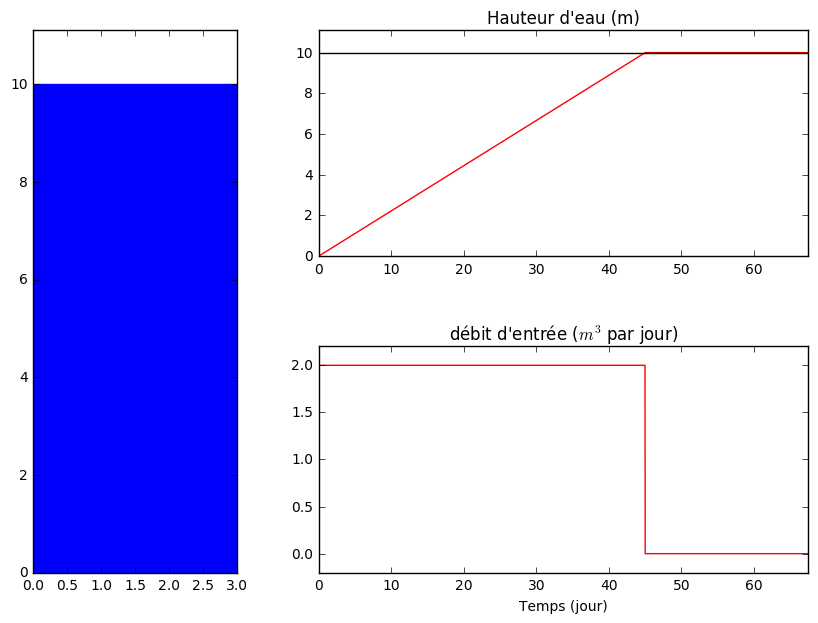

In [44]:
# Remplissage d'un réservoir par une loi de commande boucle ouverte, 
# sans prise en compte ni des précipitations ni de l'utilisation de l'eau par les agriculteurs
remplissage(0,0)

La commande boucle ouverte proposée permet de remplir le réservoir au volume souhaité.

Cependant, cela ne va marcher que dans le cas où il n'y a aucun aléa, et où le système est parfaitement connu. Si on se place dans un cas plus réaliste, c'est à dire moins idéal, il faudra prendre en compte dans le système le fait qu'il peut pleuvoir (entrée supplémentaire du système), que des personnes vont utiliser l'eau de ce réservoir (sortie supplémentaire) et qu'il y a des imperfections dans le système qui font que la valeur de débit maximal n'est pas exactement égale à $d_{\text{max}}$ et peut même varier légèrement dans le temps. Dans ces cas là, l'application de la commande en boucle ouverte ne conduira pas exatement au volume souhaité. C'est pourquoi on utilise des commandes en boucle fermée qui peuvent être robustes aux aléas, incertitudes et erreurs de modélisation.

En effet, en notant $p$ le débit d'entrée dû aux précipitations et $c$ le débit de sortie dû à la consommation des agriculteurs, le modèle s'écrit maintenant:
\begin{equation}
 \dot{h}=\frac{d+p-c}{b},
\end{equation}
où $d$ est le débit de pompage dans la nappe fréatique.

La simulation du système commandé en boucle ouverte donne maintenant les résultats suivants, qui montre que l'on atteint pas le niveau d'eau désiré.

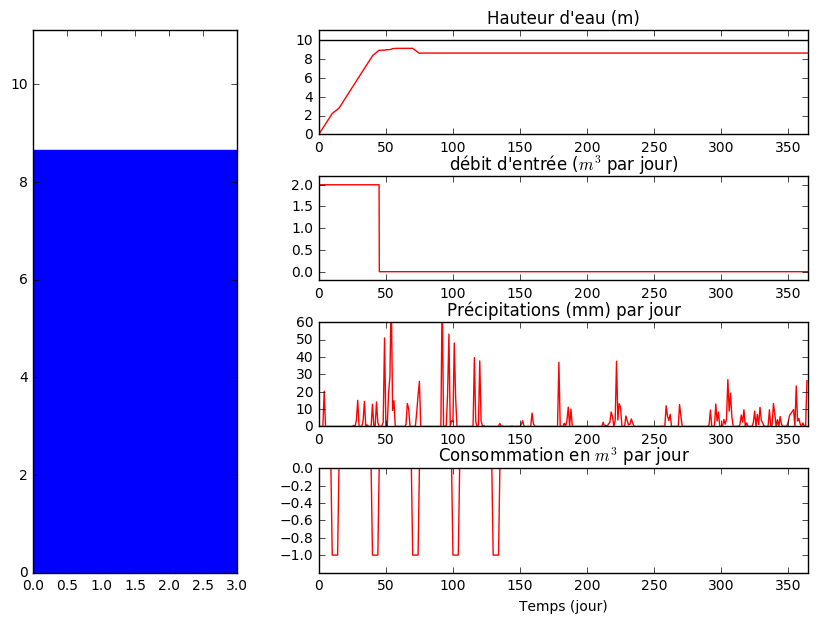

In [45]:
# Remplissage d'un réservoir par une loi de commande boucle ouverte, 
# AVEC prise en compte des précipitations et de l'utilisation de l'eau par les agriculteurs
plt.close('all') # close all figure
remplissage(1,1)

### Commande en boucle fermée ou rétroaction

> **Exemple du remplissage d'un réservoir pour l'irrigation**  
> On souhaite toujours que le réservoir soit maintenu à un volume constant $V_c$, pour satisfaire les besoins en eau des agriculteurs qui viennent se servir dans ce réservoir. Pour remplir le réservoir, on dispose toujours d'un accès à une nappe fréatique dans laquelle on peut pomper. Cependant, on souhaite maintenant tenir compte des précipitations, qui sont une seconde source (entrée) participant au remplissage du réservoir. La quantité d'eau de pluie qui tombe ne peut être contrôlée et n'est pas prévisible alors que la quantité d'eau pompée dans les nappes fréatiques peut être contrôlée via le débit de pompage $d$: ce sera l'entrée, ou commande, $u$ de notre système. 

> Dans ce cas, on s'aperçoit qu'il est impossible de proposer "à l'avance" une stratégie de pompage dans la nappe fréatique, puisque cela dépendra de la quantité de pluie tombée et de la consommation des agriculteurs! Il faut alors passer par une rétroaction, ou commande en boucle fermée, comme illustré dans la suite.   
 

> **Définition**  
> * Une **commande en boucle fermée** (ou **contrôle en boucle fermée**), aussi appelée **rétroaction** ou **feedback**, est une application $u:t\mapsto R(x(t),y(t))$ (voir figure [7](#SystemeBF)) choisie pour imposer un comportement dynamique au système d'état $x$
> * Si $u(t)=R(x(t))$ (respectivement $u(t)=R(y(t))$), on parlera de **retour d'état** (respectivement **retour de sortie**).
> * Si $R$ admet une expression analytique, on parlera de **retour** ou **commande statique**, 
> * Si $R$ n'est déterminée que via la résolution d'une équation dynamique, par exemple de la forme différentielle $\dot{u}=r(x,y,u)$, on parlera de **retour** ou **commande dynamique**. 

![Figure 7](./images/SystemeBF.jpg)
<a name="SystemeBF">Figure 7. Commande en boucle fermée (retour de sortie) d'un système différentiel d'entrées $u$ et de sorties $y$</a>

En utilisant une commande en boucle fermée, on décide d'appliquer une commande qui dépend de l'état courant (ou de la sortie) du système. On réajuste en fait la commande en fonction des informations que l'on récupère (via l'état ou la sortie) au cours du temps, ce qui permet de rectifier le comportement dans le cas d'évenements imprévus par exemple.

Souvent, on va avoir le schéma suivant:

1. On se donne une valeur à atteindre $y^\ast$ qu'on appelle **consigne**. Cette consigne peut être variable dans le temps.
2. A chaque pas de temps, on mesure la valeur de $y$
3. On compare $y$ et $y^\ast$
4. On ajuste la commande en fonction de la différence entre $y$ et $y^\ast$

![Structure générale loi de commande](./images/structureGeneraleControle.png)


> **Remarque**  
> La rétroaction est un phénomène qui se retrouve abondamment dans la nature, notamment lorsque des êtres vivants sont impliqués. Par exemple, la température du corps humain est constamment régulée: la transpiration (commande), qui dépend de la température extérieure (variable d'état mesurée), permet notamment cette régulation.  
> Le déplacement d'un animal comprend également des boucles de rétroaction: en fonction des informations visuelles perçues (variables d'état mesurées) , le système nerveux central va envoyer des signaux (commande) aux muscles pour aller dans la bonne direction.

> **Exemple**: **Remplissage d'un réservoir pour l'irrigation (suite)**  
> Dans cet exemple, on comprend bien que la quantité d'eau que l'on va pomper dans la nappe fréatique va dépendre du volume d'eau déjà présent dans le réservoir. Si on prend comme variable d'état du système la hauteur d'eau dans le réservoir, on va donc faire un retour d'état.
> On suppose que l'on peut mesurer la hauteur d'eau $h$ dans le réservoir et que l'on connait l'air de la base $b$ du réservoir, de sorte que le volume soit directement déduit de la hauteur d'eau mesurée par la relation $V=b\times h$. Pendant le remplissage, on va donc avoir une équation d'état de la forme:
> \begin{equation}
 \dot{h}=\frac{d+p-c}{b},
\end{equation}
> où $d$ est le débit de pompage dans la nappe fréatique, $p$ est le débit d'entrée dû aux précipitations et $c$ est le débit de sortie dû à la consommation des agriculteurs.  

> Une loi de commande boucle fermée que l'on peut proposer est la suivante:
> \begin{equation}
 d=\alpha\,b(h_c- h)
\end{equation}
où $h_c=\frac{V_c}{b}$ et $\alpha>0$.
> En supposant que la mesure de la hauteur soit exacte, on a alors une dynamique du système en boucle fermée donnée par:
> \begin{equation}
 \dot{h}=\alpha(h_c-h)+\frac{p-c}{b}.
\end{equation}
> Si $p$ et $c$ sont ponctuelles et de valeurs pas trop grandes, alors $h$ va toujours tenter de se rapprocher de $h_c$.
> En fait, $p$ et $c$ peuvent être considérées comme des perturbations du système $\dot{h}=\alpha(h_c-h)$ qui est une équation d'un système du premier ordre telle que $h(t) \underset{t \rightarrow \infty}{\longrightarrow} h_c$.

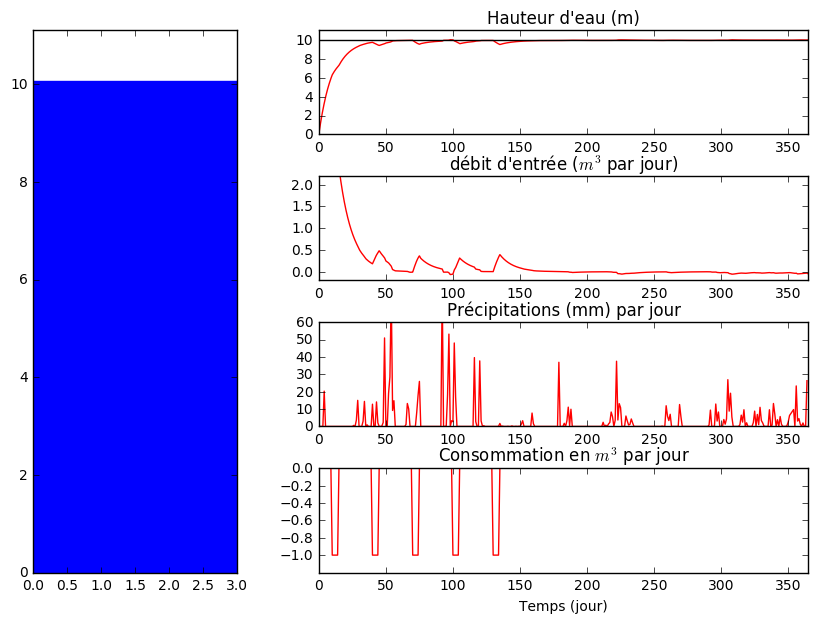

In [46]:
# Remplissage d'un réservoir par une loi de commande boucle fermée
# AVEC prise en compte ni des précipitations ni de l'utilisation de l'eau par les agriculteurs

plt.close('all') # close all figure
def fonction_u(t,T,dmax,base,Vc,precip,conso,x):
    coeffalpha=0.1
    valu = base*coeffalpha*(Vc/base-x)
    return valu

remplissage(1,1)

### Quelques lois de commande boucle fermée classiques

Notons $y^m(t)$ la mesure de $y(t)$ à l'instant $t$. Voici deux lois de commande classiquement appliquées:

1. Commande "bang-bang" ou "tout ou rien":

$$ u(t)=\left\{
\begin{array}{c}
 u_{max}\text{ if }y^\ast-y^m(t)>0\\
 u_{min}\text{ if }y^\ast-y^m(t)\leqslant 0
\end{array}
\right.$$

2. Commande proportionnelle intégrale dérivée (PID)

$$ u(t)=u_c+K_p(y^\ast-y^m(t))+K_i\int_0^t(y^\ast-y^m(s))ds+K_d\frac{d(y^\ast-y^m)}{dt}(t)$$

## <a name="PID">Contrôleur Proportionnel Intégral Dérivé (PID)</a>

La commande proportionnelle intégrale dérivée (PID) est, comme son nom l'indique, composée de 3 termes:
- un terme proportionnel à l'erreur $y^\ast-y^m$
- un terme proportionnel à l'intégral de l'erreur $y^\ast-y^m$
- et un terme proportionnel à la dérivée de l'erreur $y^\ast-y^m$

$$ u(t)=u_c+\underbrace{K_p(y^\ast-y^m(t))}_{\text{proportionnel}}+\underbrace{K_i\int_0^t(y^\ast-y^m(s))ds}_{\text{intégral}}+\underbrace{K_d\frac{d(y^\ast-y^m)}{dt}(t)}_{\text{dérivé}} $$

Nous allons illustrer ses performances sur un exemple concret.


### Exemple : Culture de micro-organismes dans un réacteur continu

On va s'intéresser à l'exemple de la croissance d'une population de micro-organismes que l'on notera $B$ (pour biomasse) sur un substrat noté $S$ dans un réacteur continu (c'est à dire à volume constant et alimenté en continu) et parfaitement mélangé. Cette réaction peut être schématiquement représentée de la manière suivante:

$$ S \underset{B}{\longrightarrow} B$$

la présence du $B$ sous la flèche signifiant que $B$ est un catalyseur de sa propre croissance (la vitesse de la réaction, qui est le taux de croissance de la population va donc dépendre de $B$). On supposera que le taux de croissance $\mu(S)$ de ces micro-organismes suit une loi de Haldane:

$$ \mu(S)=\frac{\mu^\ast S}{K_S+S+\frac{S^2}{K_I}}\text{ avec }1-4\frac{K_s}{K_I}<0$$

Cette fonction admet un maximum en $S=\sqrt{K_sK_I}$ valant $\mu_{max}=\frac{\mu^\ast}{1+2\sqrt{\frac{K_S}{K_I}}}$.

**Remarques mathématiques:**

- <u>Valeur maximum</u>: pour trouver le maximum de la fonction $\mu$, il suffit de résoudre l'équation $\mu^\prime(S)=0$ et de choisir ensuite parmi les solutions la plus grande valeur parmi les maximas locaux (car les solutions peuvent aussi des minimas). Dans notre cas on a: $\mu^\prime(S)= \frac{\mu^\ast}{\left(K_S+S+\frac{S^2}{K_I}\right)^2}\left(K_S-\frac{S^2}{K_I}\right)$. Les valeurs de $S$ pour lesquelles $\mu^\prime(S)=0$ sont donc telles que $S^2=K_SK_I \Leftrightarrow S=\pm \sqrt{K_sK_I}$. Comme on ne s'intéresse qu'aux valeurs positives de $S$ (valeurs physiques) on ne retiendra que la valeur $S=\sqrt{K_sK_I}$ dont on peut montrer que c'est un maximum. En effet, pour tout $S\in[0,\sqrt{K_SK_I}],\,\mu^\prime(S)>0$ et pour tout $S\in[\sqrt{K_SK_I},\infty ),\,\mu^\prime(S)<0$.
- <u>Condition</u> $1-4\frac{K_s}{K_I}<0$: cette condition permet d'assurer que $\mu(S)>0$ pour tout $S>0$. En effet, $\mu(S)>0 \Leftrightarrow K_S+S+\frac{S^2}{K_I}>0$. Le discriminant de ce polynôme est donné par $\Delta = 1-4\frac{K_S}{K_I}$. Si $\Delta<0$ alors le polynôme $K_S+S+\frac{S^2}{K_I}$ n'admet aucune racine réelle et $K_S+S+\frac{S^2}{K_I}>0,\,\forall S>0$. Si $Delta>0$ alors le polynôme $K_S+S+\frac{S^2}{K_I}$ admet deux racines réelles qui sont toutes deux positives. Par conséquent il existera des valeurs de $S>0$ pour lesquelles $K_S+S+\frac{S^2}{K_I}<0$ ce qui n'a pas de signification biologique. 

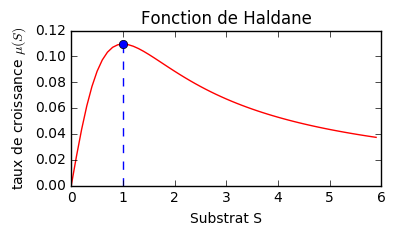

In [47]:
# Tracé de la fonction de Haldane
# -------------------------------
# vecteur de valeurs de S
S= np.arange(0,6,0.1)
# paramètres de la fonction de Haldane
muast = 2.3; KS = 10; KI = 0.1;
# taux de croissance
mu=muast*S/(KS+S+S**2/KI)
# Valeur de S pour laquelle le taux de croissance est maximum
Smax=np.sqrt(KS*KI)
# Valeur maximale du taux de croissance
mumax=muast*Smax/(KS+Smax+Smax**2/KI)

# Tracé de la fonction de Haldane
plt.figure(figsize = (4, 2))
plt.plot(S,mu,'r')
plt.plot(Smax*np.array([1,1]),np.array([0,mumax]),'b--')
plt.plot(Smax,mumax,'bo')
plt.xlabel('Substrat S')
plt.ylabel('taux de croissance $\mu(S)$')
plt.title('Fonction de Haldane')
plt.show()

On notera $Q$ le débit d'alimentation du réacteur (égal au débit de soutirage) et $V$ le volume constant du réacteur.

Un modèle de ce système est donné par:

$$
\boxed{
\left\{
\begin{array}{crl}
\frac{dB}{dt}= & \mu(S)B &-\frac{Q}{V}B\\
\frac{dS}{dt}= & -k\mu(S)B&+\frac{Q}{V}(S_0-S)  \\
\end{array}
\right.}
$$

> **Problème**: on cherche à contrôler la concentration $S$ de substrat dans le réacteur en jouant sur la commande $Q$.
> On note $S^\ast$ la valeur de la concentration en sucre que l'on souhaite atteindre. 

### Loi de commande boucle ouverte

Avant de tester un commande PID, on va regarder ce que donne la commande boucle ouverte.

Trouver la loi de commande boucle ouverte du problème consiste à trouver la valeur $Q^\ast$ de $Q$ qui, si elle est appliquée au système, amènera la concentration en sucre $S$ à la valeur $S^\ast$.

Autrement dit, on cherche la valeur $Q^\ast$ de $Q$ telle que $S^\ast$ (et la valeur de $B$ correspondante) est un point d'équilibre stable du système.

Avant de chercher cette valeur $Q^\ast$, on va d'abord se poser la question suivante:

> **Question**: Quelles sont les valeurs $S^\ast$ que l'on peut atteindre avec une loi de commande boucle ouverte (c'est à dire avec une valeur de $Q$ constante et positive)?

Répondre à cette question revient à calculer les points d'équilibre du système qui sont stables. On va donc chercher dans un premier temps l'ensemble des points d'équilibre, c'est à dire les valeurs de $S$ et $B$ telles que:

$$ \left\{
\begin{array}{rl}
(\mu(S) -\frac{Q}{V})B &=& 0\\
-k\mu(S)B+\frac{Q}{V}(S_0-S) &=& 0 \\
\end{array}\right. $$

En supposant que $Q>0$ (donc non nul) on a:

$$\left\{ \begin{array}{rl}
(\mu(S) -\frac{Q}{V})B &=& 0\\
-k\mu(S)B+\frac{Q}{V}(S_0-S) &=& 0 \\
\end{array}\right.
\Longleftrightarrow \left\{
\begin{array}{rl}
B &=& 0\\
\frac{Q}{V}(S_0-S) &=& 0 \\
\end{array}\right.
\text{ ou }
\left\{
\begin{array}{rl}
\frac{Q}{V} &=& \mu(S)\\
\mu(S)(S_0-S-kB) &=& 0 \\
\end{array}\right. $$

$$ 
\Longleftrightarrow 
\left\{
\begin{array}{rl}
B &=& 0\\
S &=& S_0 \\
\end{array}\right.
\text{ ou } 
\left\{
\begin{array}{rl}
\mu(S) &=& \frac{Q}{V}\\
B&=& \frac{S_0-S}{k} \\
\end{array}\right. $$

Il nous faut donc encore résoudre l'équation $\mu(S)=\frac{Q}{V}$. En remplaçant $\mu(S)$ par son expression, on obtient l'équation suivante:

$$ \frac{\mu^\ast S}{K_S+S+\frac{S^2}{K_I}}=\frac{Q}{V} $$

qui, si on la multiplie par $K_S+S+\frac{S^2}{K_I}$ (qui est toujours strictement positif), et après réarrangement, donne:

$$ \frac{Q}{V}K_S+(\frac{Q}{V}-\mu^\ast) S+\frac{Q}{V}\frac{S^2}{K_I}=0.$$

On peut montrer que, pour $0 < Q < V \frac{\mu^\ast}{1+2\sqrt{\frac{K_S}{K_I}}}$
cette équation admet deux solutions (racines du polynôme en $S$) notées $S_1$ et $S_2$ telles que
$$0 ≤  S_1 ≤  \sqrt{K_SK_I} ≤  S_2$$.

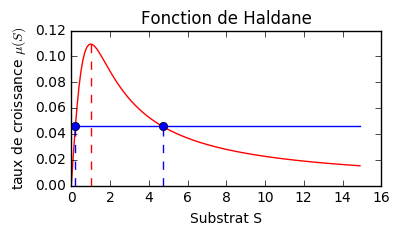

<function __main__.test>

In [48]:
# Calcul des points d'équilibre du modèle de réacteur continu
# ------------------------------------------------------------

def test(Q):
    # calcul des racines r1 et r2 du polynome Q*KS/V+(Q/V-muast)*S+Q/(V*KI)*S^2
    r=np.roots(np.array([Q/(V*KI),Q/V-muast,Q*KS/V]))
    
    # Valeur du taux de croissance en r1
    mur0 = muast*r[0]/(KS+r[0]+r[0]**2/KI)
    # Valeur du taux de croissance en r2
    mur1 = muast*r[1]/(KS+r[1]+r[1]**2/KI)
    # --> en principe, on a mur1=mur2=Q/V
    
    # Valeur de S pour laquelle le taux de croissance est maximum
    Smax = np.sqrt(KS*KI)
    # Valeur maximale du taux de croissance
    mumax = muast*Smax/(KS+Smax+Smax**2/KI)
    # Vecteur de valeurs
    S= np.arange(0,max(max(r),15),0.1)
    # Taux de dilution D=Q/V
    D=Q/V
    # taux de croissance calculé en les valeurs de S
    mu=muast*S/(KS+S+S**2/KI)
    
    # Tracé de l'intersection entre la fonction de Haldane et la droite d'equation y=Q/V
    plt.figure(figsize = (4, 2))
    plt.plot(S,mu,'r')
    plt.plot(np.array([0,S[-1]]),D*np.array([1,1]),'b')
    plt.plot(r[0]*np.array([1,1]),np.array([0,mur0]),'b--')
    plt.plot(r[0],mur0,'bo')
    plt.plot(r[1]*np.array([1,1]),np.array([0,mur1]),'b--')
    plt.plot(r[1],mur1,'bo')
    plt.plot(Smax*np.array([1,1]),np.array([0,mumax]),'r--')
    plt.xlabel('Substrat S')
    plt.ylabel('taux de croissance $\mu(S)$')
    plt.title('Fonction de Haldane')
    plt.show()

# paramètres de la fonction de Haldane
muast = 2.3; KS = 10; KI = 0.1;Qin = 0.01; V = 0.5;
# valeur maximale Qmax du débit d'entrée Q que l'on peut appliquer 
Qmax = V*muast/(1+2*np.sqrt(KS/KI))

# Evolution des solutions de l'équation mu(S)=Q/V en fonction de la valeur de Q appliquée --> tracé intéractif
interact(test,Q=(0.001,Qmax,Qmax/10))

On a donc $3$ points d'équilibre qui sont:

- $E_0=(B,S) = (0,S_0)$ : ce point d'équilibre correspond au lessivage, c'est à dire à la disparition totale de la population de micro-organismes
- $E_1=(B,S) = (\frac{S_0-S_1}{k},S_1)$ 
- $E_2=(B,S) = (\frac{S_0-S_2}{k},S_2)$ 

Si on s'intéresse maintenant à la stabilité (locale) de ces points d'équilibre, on peut montrer (admis) que:
- $E_0$ est stable si et seulement si $\frac{Q}{V}>\mu(S_0)$
- $E_1$ est stable 
- $E_2$ est instable

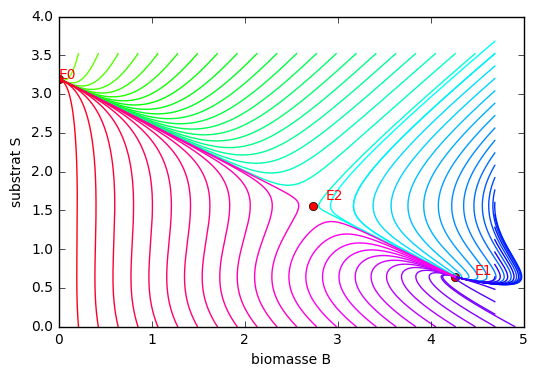

In [49]:
# Tracé du portrait de phase du modèle de réacteur continu
# --------------------------------------------------------

# Paramètres du modèle de réacteur continu
muast = 2.3; KS = 10; KI = 0.1;Q = 0.05; V = 0.5; S0 = 3.2; coeffk = 0.6;

# modèle du réacteur continu
def reacteur(x,t,coeffk,muast,KS,KI,Q,V,S0):
    B = x[0] #biomasse
    S = x[1] #substrat
    
    # initialisation de la dérivée de x par rapport au temps
    dx = np.zeros(2)
    # taux de croissance
    mu = muast*S/(KS+S+S**2/KI)
    
    # second membre de l'équation en B
    dx[0] = mu*B-Q/V*B
    # second membre de l'équation en S
    dx[1] = -coeffk*mu*B+Q/V*(S0-S)
    return dx

# ** Calcul des points d'équilibre
# pour cela, on calcul les racines r1 et r2 du polynome Q*KS/V+(Q/V-muast)*S+Q/(V*KI)*S^2
r=np.roots(np.array([Q/(V*KI),Q/V-muast,Q*KS/V])) 

# ** Positionnement des points d'équilibre sur le portrait de phase
# - point d'équilibre E2
plt.plot((S0-r[0])/coeffk,r[0],'ro')
plt.text((S0-r[0])/coeffk*1.05,r[0]*1.05,'E2',color='r')
# - point d'équilibre E1
plt.plot((S0-r[1])/coeffk,r[1],'ro')
plt.text((S0-r[1])/coeffk*1.05,r[1]*1.05,'E1',color='r')
# - point d'équilibre E0
plt.plot(0,S0,'ro')
plt.text(0,S0,'E0',color='r')


# ** Tracé du portrait de phase
# Pour tracer le portrait de phase, on va simuler plusieurs trajectoires solutions du modèle
# en changeant à chaque fois la condition initiale et on va les tracer dans le plan de phase 
# c'est à dire que l'on va tracer les valeurs de S en fonction de B (ou l'inverse)
# On ne s'intéressera évidemment qu'à la partie du plan de phase où B>0 et S>0 puisque seules ces valeurs 
# ont une signification biologique

# comme on ne peut pas tracer le portrait de phase entier, car le plan de phase est infini, on va
# définir des bornes Bmax et Smax pour les valeurs de B et de S
Bmax=(max(S0-r)/coeffk)*1.1
Smax=max(max(r),S0)*1.1

# pour chaque bord de ce sous-domaine [0,Bmax]x[0,Smax] on va simuler nbinit+1 trajectoires qui partent de ce bord
nbinit = 22 # nombre de conditions initiales par bord
    
# on définit également une plage de temps sur laquelle on va simuler les trajectoires
tmax=200
temps = np.linspace(0,tmax,20000)

# et on choisit les couleurs pour le tracé des trajectoires sur le portrait de phase
cmap = plt.get_cmap('hsv')
couleurs = [cmap(i) for i in np.linspace(0, 1, 4*(nbinit+1))]

# numéro de la simulation qui sera incrémenté
nb_simu = 0

for k in np.arange(4): # boucle sur les 4 bords de la partie du plan de phase à laquelle on s'intèresse
    for l in np.arange(nbinit+1): # boucle sur les nbinit+1 conditions initiales du bord considéré
        # initialisation de la condition initiale
        x0 = np.zeros(2)
        
        if k == 0: # bord 0 : B=0 et 0<S<Smax
            x0[0]=0
            x0[1]= l*Smax/nbinit
        elif k==1: # bord 1 : S=Smax et 0<B<Bmax
            x0[0]=l*Bmax/nbinit
            x0[1]=Smax
        elif k==2: # bord 2 : B=Bmax et 0<S<Smax
            x0[0]=Bmax
            x0[1]=(nbinit+1-l)*Smax/nbinit
        elif k==3: # bord 3 : S=0 et 0<B<Bmax
            x0[0]=(nbinit+1-l)*Bmax/nbinit
            x0[1]=0
          
        # simulation du modèle
        X = scint.odeint(reacteur,x0,temps,args=(coeffk,muast,KS,KI,Q,V,S0))
        # tracé de la trajectoire solution dans le plan de phase
        plt.plot(X[:,0],X[:,1],color=couleurs[nb_simu])
        # incrémentation du numéro de la simulation
        nb_simu = nb_simu + 1

# titres des axes des abscisses et ordonnées
plt.xlabel('biomasse B')
plt.ylabel('substrat S')
plt.show()


En conclusion, on a montré que les seuls points d'équilibre atteignables avec une commande boucle ouverte sont $E_0$ et $E_1$. Comme $0 ≤  S_1 ≤  \sqrt{K_SK_I}$ les seules valeurs $S^\ast$ atteignables avec une commande boucle ouverte sont:

$$S^\ast \in\left[0,\sqrt{K_SK_I}\right]\cup \left\{S_0 \right\}$$

On retourne maintenant à la question de départ qui était:

> **Question**: Etant donnée une valeur atteignable $S^\ast$ de $S$, quelle est la valeur $Q^\ast$ de $Q$ telle que $S$ tende vers $S^\ast$?

Dans notre cas, on a vu que les points d'équilibre $E_1$ et $E_2$ étaient caractérisés par $\mu(S)=\frac{Q}{V}$.
Pour atteindre $S^\ast$ il faudra donc appliquer un débit $Q^\ast$ égal à:
$$Q^\ast=V \mu(S^\ast)$$

In [50]:
# Controle boucle ouverte de la culture bactérienne dans un réacteur continu
# --------------------------------------------------------------------------
plt.close('all') # close all figure

# ** modèle du réacteur continu
def reacteur(x,t,k,muast,KS,KI,Qin,V,S0,Sast,control_type,coeffcontrol,disturb):
    # x : variables d'état du modèle c'est à dire B et S dans notre cas
    # t : temps
    # muast, KS, KI : paramètres de la fonction de Haldane utilisée pour le taux de croissance
    # Qin : débit d'entrée dans le réacteur
    # S0 : concentration en sucre dans le milieu qui alimente le réacteur
    # Sast : consigne en concentration en sucre pour la commande (= valeur que l'on veut atteindre)
    # control_type : type de loi de commande à appliquer. Pour l'instant un type est possible control_type='BO'
    #                pour la boucle ouverte
    # coeffcontrol : paramètres utilisés dans la loi de commande
    # disturb : perturbation sur la commande c'est à dire valeur telle que Qréel = Qcalc*(1+disturb)
    
    # récupération des valeurs des variables d'état
    B = x[0] # biomasse
    S = x[1] # substrat
    # Calcul de la commande: dans fonction_u la loi de commande est calculée, disturb permet de prendre
    # en compte d'éventuelles perturbation sur la valeur réellement appliquée de la commande
    Q = fonction_u(t,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)*(1+disturb)
    # initialisation de dx, second membre du modèle correspondant à la dérivée des variables d'état dB/dt et dS/dt
    dx = np.zeros(2)
    # taux de croissance (fonction de Haldane)
    mu = muast*S/(KS+S+S**2/KI)
    # second membre de l'équation en B
    dx[0] = mu*B-Q/V*B
    # second membre de l'équatio en S
    dx[1] = -k*mu*B+Q/V*(S0-S)
    return dx

# ** fonction qui simule le modèle avec la loi de commande demandée et qui trace ensuite la solution
def culture_cont(Sast,control_type,coeffcontrol,disturb):
    
    # vecteur de temps pour la simulation
    tmax = 150
    temps = np.linspace(0,tmax,2000) 

    # paramètres du modèle
    k = 0.6; muast = 2.3; KS = 10; KI = 0.1; Qin = 0.01; V = 0.5; 
    
    # conditions initiales du modèle (valeurs initiales de la biomasse et de la concentration en sucre)
    B0 = 9; S0 = 3.2; 
    
    # si on utilise un terme intégrale, il faudra rajouter une équation dans le modèle et du coup rajouter
    # la condition initiale correspondante qui est égale à 0 (voir plus loin dans le paragraphe sur le terme
    # intégral)
    if control_type in ['I','PI','PID']: 
        x0 = np.array([B0,S0,0])
    else: 
        x0 = np.array([B0,S0])
        
    # intégration numérique de l'EDO
    x = scint.odeint(reacteur,x0,temps,args=(k,muast,KS,KI,Qin,V,S0,Sast,control_type,coeffcontrol,disturb))
    
    # re-calcul de la commande appliquée
    u = fonction_u(temps,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)

    # tracé des solutions
    plt.figure(figsize = (10, 3))
    plt.subplots_adjust(hspace=0.4,wspace=0.4)
    plt.subplot2grid((1,2),(0,0))
    plt.plot(temps,x[:,0],'r',label='Biomasse')
    plt.plot(temps,x[:,1],'g',label='Substrat')
    plt.plot(np.array([0,temps[-1]]),np.array([Sast,Sast]),'g--',label='S*')
    plt.legend(); plt.xlabel('time (h)')
    
    plt.subplot2grid((1,2),(0,1))
    plt.plot(temps,u,'r',label='Debit')
    plt.legend(); plt.xlabel('time (h)')
    plt.show()

# Loi de commande
def fonction_u(t,x,Sast,k,muast,KI,KS,V,SO,control_type,coeffcontrol):
    if control_type == 'BO': # BOUCLE OUVERTE
        # loi donnée par Qast=mu(Sast)*V
        Qast=muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float: # cas où t est scalaire 
            valu = Qast
        else: # cas où t est un vecteur
            valu = np.ones(len(t))*Qast    
    return valu

**Test 1**: Loi de commande en BOUCLE OUVERTE, SANS PERTURBATION

Ici $k = 0.6$; $\mu^\ast = 2.3$; $K_S = 10$; $K_I = 0.1$; $S^{in} = 3.2$; $V = 0.5$;

donc les valeurs de $S$ atteignables sont $\left[0,\sqrt{K_SK_I}\right]\cup \left\{S^{in} \right\}=[0,1]\cup\left\{3.2  \right\}$

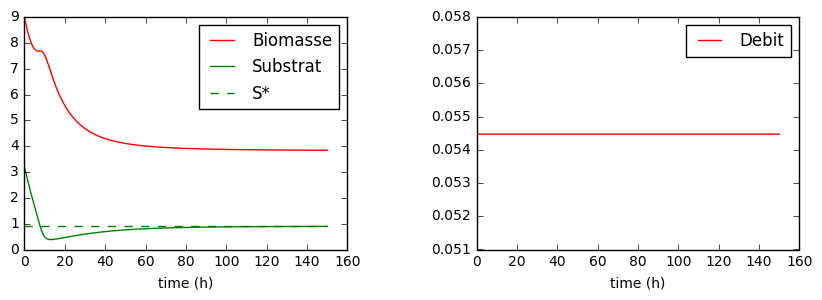

<function __main__.test>

In [51]:
# tracé interactif de l'évolution de la dynamique boucle fermée en fonction de la valeur de Sast 
# dans le cas d'une commande en BOUCLE OUVERTE SANS PERTURBATION
def test(Sast):
    return culture_cont(Sast,'BO',0,0)
interact(test,Sast=(0,2,0.1))

On constate donc que, si on choisit une valeur de consigne $S^\ast$ atteignable, alors la loi de commande boucle ouverte permet bien de faire tendre la concentration en sucre vers cette valeur de consigne. 

Ce n'est par contre plus le cas si on choisit un $S^\ast>\sqrt{K_SK_I}$

Regardons maintenant si cette loi de commande est robuste aux perturbations.

Supposons que pour des raisons physiques, il y a une erreur entre le débit que l'on souhaite appliqué (et qui est donné par la loi de commande), et le débit qui est réellement appliqué.

$$ Q_{réel}=Q_{calc}(1+\delta)$$

**Test 2**: Loi de commande en BOUCLE OUVERTE, AVEC PERTURBATION 

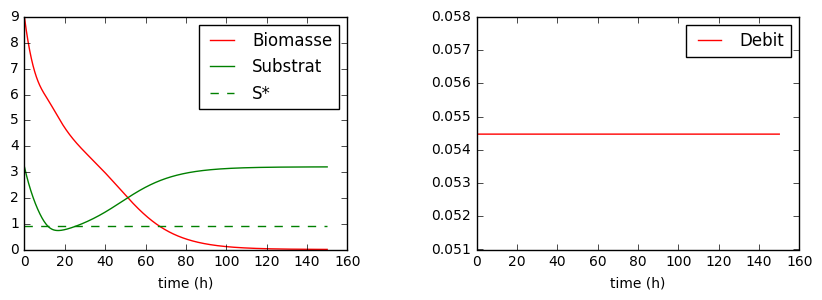

<function __main__.test>

In [52]:
# tracé interactif de l'évolution de la dynamique boucle fermée en fonction de la valeur de Sast 
# dans le cas d'une commande en BOUCLE OUVERTE AVEC PERTURBATION
def test(Sast,disturb):
    return culture_cont(Sast,'BO',0,disturb)
interact(test,Sast=(0,2,0.1),disturb=(0,0.4,0.01))

#### Limites de la boucle ouverte

On touche ici aux limites de la commande boucle ouverte.

- la commande boucle ouverte ne peut être utilisée que pour certaines valeurs de consignes
- cette commande n'est pas robuste aux perturbations

### Action proportionnelle

On va maintenant tester une loi de commande boucle fermée constituée d'un terme proportionnel à l'erreur, c'est à dire une loi de commande de la forme:

$$ u(t)=u^\ast+K_p(y^\ast-y^m(t))$$

où $u^\ast$ est la valeur de la loi de commande constante boucle ouverte qui permet de stabiliser le système à $S^\ast$

Dans le cas de notre exemple, cela correspondant à la loi de commande:

$$ Q(t)=V\mu(S^\ast)+K_p(S^\ast-S^m(t))$$

In [53]:
# Contrôle boucle fermée de la culture bactérienne dans un réacteur continu :  commande proportionnelle
# -----------------------------------------------------------------------------------------------------

# Loi de commande
def fonction_u(t,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol):
    if control_type == 'BO': # BOUCLE OUVERTE
        # loi donnée par Qast=mu(Sast)*V
        Qast = muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float:  # cas où t est scalaire 
            valu = Qast
        else: # cas où t est un vecteur
            valu = np.ones(len(t))*Qast
    elif control_type == 'P': # BOUCLE FERMEE action PROPORTIONNELLE
        # récupération des paramètres de la loi de commande
        kprop = coeffcontrol
        # et de la valeur de S
        if type(t)==float: # cas où t est scalaire 
            valS = x[1]
        else: # cas où t est un vecteur
            valS = x[:,1]
        # loi donnée par mu(Sast)*V+kprop*(Sast-S)
        valu = muast*Sast/(KS+Sast+Sast**2/KI)*V+kprop*(Sast-valS)    
    return valu

**Test**: Loi de commande en BOUCLE FERMEE avec action proportionnelle (P), SANS PERTURBATION 

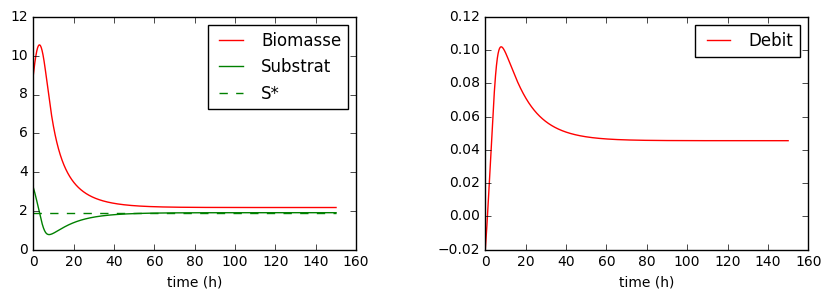

<function __main__.test>

In [54]:
# tracé interactif de l'évolution de la dynamique boucle fermée en fonction de la valeur de Sast et kprop
# dans le cas d'une commande en BOUCLE FERMEE PROPORTIONNELLE SANS PERTURBATION
def test(Sast,kprop):
    return culture_cont(Sast,'P',kprop,0)
interact(test,Sast=(0,4,0.1),kprop=(0,0.1,0.01))

Comparé à la commande en boucle ouverte, on constate qu'avec la commande boucle fermée avec terme proportionnel, on peut atteindre des valeurs $S^\ast$ de $S$ qui étaient non atteignables avec la boucle ouverte.

Testons maintenant si cette commande est robuste aux perturbations.

**Test**: Loi de commande en BOUCLE FERMEE avec action proportionnelle (P), AVEC PERTURBATION

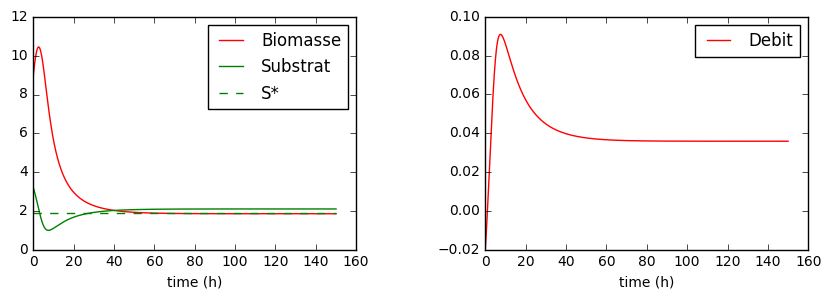

<function __main__.test>

In [55]:
# tracé interactif de l'évolution de la dynamique boucle fermée en fonction de la valeur de Sast, kprop et disturb
# dans le cas d'une commande en BOUCLE FERMEE PROPORTIONNELLE AVEC PERTURBATION
def test(Sast,kprop,disturb):
    return culture_cont(Sast,'P',kprop,disturb)
interact(test,Sast=(0,4,0.1),kprop=(0,0.1,0.01),disturb=(0,0.4,0.01))

On constate que la commande boucle fermée proportionnelle n'est pas robuste aux perturbations.

Rajoutons maintenant un terme intégral à cette loi de commande.

### Action intégrale

On va donc maintenant tester une loi de commande boucle fermée constitué d'un terme proportionnel à l'erreur et d'un terme proportionnel à l'intégrale de l'erreur, c'est à dire une loi de commande de la forme:

$$ u(t)=K_0+K_p(y^\ast-y^m(t))+K_i\int_0^t(y^\ast-y^m(s))ds$$

Dans le cas de notre exemple, cela correspondant à la loi de commande:

$$ Q(t)=K_0+K_p(S^\ast-S^m(t))+K_i\int_0^t(S^\ast-S^m(s))ds$$

**Remarque** on voit ici que la valeur $u^\ast$ de la commande constante boucle ouverte n'apparait plus dans l'expression de la loi de commande: elle a été remplacée par le terme constant $K_0$ En effet, on va voir qu'il n'est ici plus nécessaire de connaitre la valeur de la loi de commande boucle ouverte pour contrôler le système: c'est l'intégrateur qui va assurer que l'on converge bien vers la consigne. La valeur de $K_0$ permettra quant à elle de choisir la valeur de la commande au départ (au moment où on appliquer la commande). Cela peut être utile pour éviter des discontinuités, autrement dit des changements brutaux de valeur de commande.

**Application pratique**

Numériquement, pour calculer le terme $I=\int_0^t(S^\ast-S^m(s))ds$ on va simplement rajouter l'équation suivante:

$$ \frac{dI}{dt}=S^\ast - S^m$$
avec $I(0)=0$.

In [56]:
# Contrôle boucle fermée de la culture bactérienne dans un réacteur continu :  commande proportionnelle et intégrale
# ------------------------------------------------------------------------------------------------------------------

# Loi de commande
def fonction_u(t,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol):
    if control_type == 'BO': # BOUCLE OUVERTE
        # loi donnée par Qast=mu(Sast)*V
        Qast = muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float:  # cas où t est scalaire 
            valu = Qast
        else: # cas où t est un vecteur
            valu = np.ones(len(t))*Qast
    elif control_type == 'P': # BOUCLE FERMEE action PROPORTIONNELLE
        # récupération des paramètres de la loi de commande
        kprop = coeffcontrol
        # et de la valeur de S
        if type(t)==float: # cas où t est scalaire 
            valS = x[1]
        else: # cas où t est un vecteur
            valS = x[:,1]
        # loi donnée par mu(Sast)*V+kprop*(Sast-S)
        valu = muast*Sast/(KS+Sast+Sast**2/KI)*V+kprop*(Sast-valS)    
    elif control_type == 'PI': # BOUCLE FERMEE action PROPORTIONNELLE INTEGRALE
        # récupération des paramètres de la loi de commande
        k0 = coeffcontrol[0]
        kprop = coeffcontrol[1]
        kint = coeffcontrol[2]
        # et de la valeur de valint, qui est l'intégrale entre 0 et t de Sast-S
        if type(t)==float: # cas où t est scalaire 
            valint = x[2]; valS = x[1]
        else: # cas où t est un vecteur
            valint = x[:,2]; valS = x[:,1]
        # loi donnée par k0+kprop*(Sast-S) + kint*valint
        # où valint est l'intégrale entre 0 et t de Sast-S
        valu = k0+kprop*(Sast-valS)+kint*valint    
    return valu

# modification du modèle de réacteur continu pour calculer l'intégrale de Sast-S au cours du temps
def reacteur(x,t,k,muast,KS,KI,Qin,V,S0,Sast,control_type,coeffcontrol,disturb):
    # x : variables d'état du modèle c'est à dire B et S dans notre cas
    # t : temps
    # muast, KS, KI : paramètres de la fonction de Haldane utilisée pour le taux de croissance
    # Qin : débit d'entrée dans le réacteur
    # S0 : concentration en sucre dans le milieu qui alimente le réacteur
    # Sast : consigne en concentration en sucre pour la commande (= valeur que l'on veut atteindre)
    # control_type : type de loi de commande à appliquer. Pour l'instant un type est possible control_type='BO'
    #                pour la boucle ouverte
    # coeffcontrol : paramètres utilisés dans la loi de commande
    # disturb : perturbation sur la commande c'est à dire valeur telle que Qréel = Qcalc*(1+disturb)
    
    # récupération des valeurs des variables d'état
    B = x[0] # biomasse
    S = x[1] # substrat
    # Calcul de la commande: dans fonction_u la loi de commande est calculée, disturb permet de prendre
    # en compte d'éventuelles perturbation sur la valeur réellement appliquée de la commande
    Q = fonction_u(t,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)*(1+disturb)
    # initialisation de dx, second membre du modèle correspondant à la dérivée des variables d'état dB/dt et dS/dt
    if control_type in ['PI','PID']: # si il y a un terme intégrale dans la commande, on rajoute une équation pour
        # calculer l'intégrale Sast-S au cours du temps
        dx = np.zeros(3)
        # second membre de l'equation qui calcule l'intégrale de Sast-S qui sera stockée dans x[2]
        dx[2] = Sast-S
    else: # si il n'y a pas de terme intégrale dans la commande, on ne rajoute pas d'équation
        dx = np.zeros(2)
    # taux de croissance (fonction de Haldane)
    mu = muast*S/(KS+S+S**2/KI)
    # second membre de l'équation en B
    dx[0] = mu*B-Q/V*B
    # second membre de l'équatio en S
    dx[1] = -k*mu*B+Q/V*(S0-S)
    return dx

**Test**: Loi de commande en BOUCLE FERMEE avec actions proportionnelle et intégrale (PI), SANS PERTURBATION

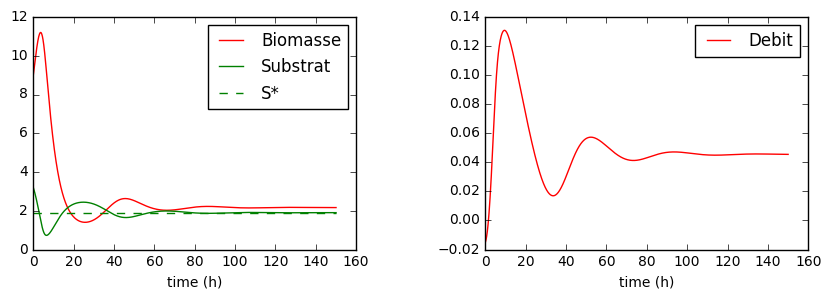

<function __main__.test>

In [57]:
# tracé interactif de l'évolution de la dynamique boucle fermée en fonction de la valeur de Sast, kprop et kint
# dans le cas d'une commande en BOUCLE FERMEE PROPORTIONNELLE INTEGRALE SANS PERTURBATION
def test(Sast,k0,kprop,kint):
    return culture_cont(Sast,'PI',np.array([k0,kprop,kint]),0)
interact(test,Sast=(0,4,0.1),k0=(0,0.1,0.01),kprop=(0,0.1,0.01),kint=(0,0.02,0.001))

**Test**: Loi de commande en BOUCLE FERMEE avec actions proportionnelle et intégrale (PI), AVEC PERTURBATION

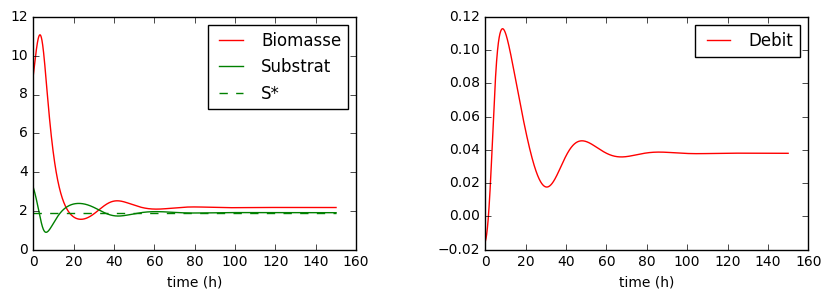

<function __main__.test>

In [58]:
# tracé interactif de l'évolution de la dynamique boucle fermée en fonction de la valeur de Sast, kprop, kint et disturb
# dans le cas d'une commande en BOUCLE FERMEE PROPORTIONNELLE INTEGRALE AVEC PERTURBATION
def test(Sast,k0,kprop,kint,disturb):
    return culture_cont(Sast,'PI',np.array([k0,kprop,kint]),disturb)
interact(test,Sast=(0,4,0.1),k0=(0,0.1,0.01),kprop=(0,0.1,0.01),kint=(0,0.02,0.001),disturb=(0,0.4,0.01))

On remarque que, en ajoutant le terme intégral dans la commande, cela permet d'annuler l'erreur que l'on faisait avec les lois de commande boucle ouverte ou boucle fermée proportionnelle.

Les lois de commande Proportionnelle Intégrale sont donc robustes aux perturbations!

### Action Dérivée

On peut également rajouter un terme dérivée dans la loi de commande boucle fermée. On obtient alors la loi de commande proportionnelle intégrale dérivée (PID) avec un terme proportionnel à l'erreur, un terme proportionnel à l'intégrale de l'erreur et un terme proportionnel à la dérivée de l'erreur, c'est à dire une loi de commande de la forme:

$$ u(t)=uK_0+K_p(y^\ast-y^m(t))+K_i\int_0^t(y^\ast-y^m(s))ds+K_d\frac{d(y^\ast-y^m)}{dt}$$

Dans le cas de notre exemple, cela correspondant à la loi de commande:

$$ Q(t)=K_0+K_p(S^\ast-S^m(t))+K_i\int_0^t(S^\ast-S^m(s))ds+K_d \frac{d(S^\ast-S^m)}{dt}$$

**Application pratique**

Numériquement, pour calculer cette loi de commande on peut remplacer $\frac{d(S^\ast-S^m(s))}{dt}=-\frac{S^m}{dt}$ (car $S^\ast$ est une constante) par le second membre de l'équation en $S$ du modèle, c'est à dire par $-k\mu(S^m)B^m+\frac{Q}{V}(S_0-S^m)$. On a alors:

$$ Q(t)=K_0+K_p(S^\ast-S^m(t))+K_i\int_0^t(S^\ast-S^m(s))ds-K_d \left(-k\mu(S^m(t))B^m(t)+\frac{Q(t)}{V}(S_0-S^m(t))\right)$$

Comme la commande $Q$ se retrouve alors dans les deux termes de l'égalité, il faut résoudre cette équation. En passant tous les termes dépendant de $Q$ dans le terme de gauche, et en multipliant par le bon coefficient on a:

$$ Q(t)=\left[K_0+K_p(S^\ast-S^m(t))+K_i\int_0^t(S^\ast-S^m(s))ds+K_d k\mu(S^m(t))B^m(t)\right] \frac{1}{1+\frac{K_d}{V}(S_0-S^m(t))}$$


In [59]:
# Contrôle boucle fermée de la culture bactérienne dans un réacteur continu: commande proportionnelle intégrale dérivée
# ---------------------------------------------------------------------------------------------------------------------

# Loi de commande
def fonction_u(t,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol):
    if control_type == 'BO': # BOUCLE OUVERTE
        # loi donnée par Qast=mu(Sast)*V
        Qast = muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float:  # cas où t est scalaire 
            valu = Qast
        else: # cas où t est un vecteur
            valu = np.ones(len(t))*Qast
    elif control_type == 'P': # BOUCLE FERMEE action PROPORTIONNELLE
        # récupération des paramètres de la loi de commande
        kprop = coeffcontrol
        # et de la valeur de S
        if type(t)==float: # cas où t est scalaire 
            valS = x[1]
        else: # cas où t est un vecteur
            valS = x[:,1]
        # loi donnée par mu(Sast)*V+kprop*(Sast-S)
        valu = muast*Sast/(KS+Sast+Sast**2/KI)*V+kprop*(Sast-valS)  
    elif control_type == 'PI': # BOUCLE FERMEE action PROPORTIONNELLE INTEGRALE
        # récupération des paramètres de la loi de commande
        k0 = coeffcontrol[0]
        kprop = coeffcontrol[1]
        kint = coeffcontrol[2]
        # et de la valeur de valint, qui est l'intégrale entre 0 et t de Sast-S
        if type(t)==float: # cas où t est scalaire 
            valint = x[2]; valS = x[1]
        else: # cas où t est un vecteur
            valint = x[:,2]; valS = x[:,1]
        # loi donnée par k0+kprop*(Sast-S) + kint*valint
        # où valint est l'intégrale entre 0 et t de Sast-S
        valu = k0+kprop*(Sast-valS)+kint*valint    
    elif control_type == 'PID': # BOUCLE FERMEE action PROPORTIONNELLE INTEGRALE DERIVEE
        # récupération des paramètres de la loi de commande
        k0 = coeffcontrol[0]
        kprop = coeffcontrol[1]
        kint = coeffcontrol[2]
        kderiv = coeffcontrol[3]
        # et des valeurs de valint (intégrale de Sast-S), de S et de B
        if type(t)==float: # cas où t est scalaire 
            valint = x[2]; valS = x[1]; valB=x[0]
        else: # cas où t est un vecteur
            valint = x[:,2]; valS = x[:,1]; valB = x[:,0]
        # loi donnée par k0+kprop*(Sast-S) + kint*valint + kderiv*(dSast/dt-dS/dt)
        mu = muast*valS/(KS+valS+valS**2/KI)
        valu = (k0+kprop*(Sast-valS)+kint*valint+kderiv*k*mu*valB)/(1+kderiv/V*(S0-valS))
    return valu

**Test**: Loi de commande en BOUCLE FERMEE avec actions proportionnelle intégrale et dérivée (PID), AVEC PERTURBATION

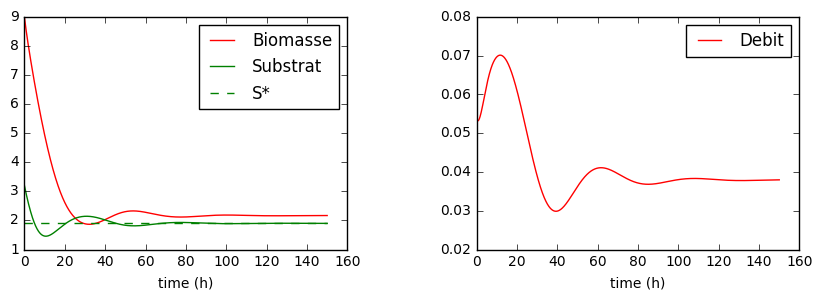

<function __main__.test>

In [60]:
# tracé interactif de l'évolution de la dynamique boucle fermée en fonction de la valeur de Sast, kprop, kint, kderiv
# et disturb dans le cas d'une commande en BOUCLE FERMEE PROPORTIONNELLE INTEGRALE DERIVEE AVEC PERTURBATION
def test(Sast,k0,kprop,kint,kderiv,disturb):
    return culture_cont(Sast,'PID',np.array([k0,kprop,kint,kderiv]),disturb)
interact(test,Sast=(0,4,0.1),k0=(0,0.1,0.01),kprop=(0,0.1,0.01),kint=(0,0.02,0.001),kderiv=(0,0.5,0.1),disturb=(0,0.4,0.01))

L'action dérivée du PID peut permettre d'accélérer la dynamique de la loi de commande boucle fermée. 

La loi de commande PID est très souvent utilisée dans l'industrie, souvent sous la forme PI dont les paramètres sont plus faciles à choisir.